<a href="https://colab.research.google.com/github/LithiumDrache/BUMachineLearningUnit/blob/main/lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Lab 04

This notebook is for clustering analysis using ``K-Means`` and ``DBSCAN``.

At the end, there are several application examples, including using ``PCA``.

## Imports

In [ ]:
# Data and structures
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Machine learning
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Metrics
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

# Stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Various / utility
import pprint as pprint

## Utility functions

Some utility functions used below.
### Stats

In [ ]:
def print_stats(n_clusters, n_noise, X, y, y_pred):
    print('Estimated number of clusters: %d' % n_clusters)
    print('Estimated number of noise points: %d' % n_noise)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))

    # and some extra metrics not explicitly mentioned in the lab tasks
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred))

### Plot cluster graph

This code has been adapted from Scikit-Learn documentation, but the original source doesn't seem to be available anymore.

In [ ]:
def plot_cluster_graph(X, y_pred, core_samples_mask, algorithm_name, n_clusters, cluster_centres=None):

    plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 9)}) # set font and plot size to be larger

    unique_labels = set(y_pred)

    colors = [plt.cm.rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [1, 1, 1, 1] # white for noise

        class_member_mask = (y_pred == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    # plots centroids, if provided
    if cluster_centres is not None:
        plt.plot(cluster_centres[:,0], cluster_centres[:,1], 'o', mew=10, ms=20, alpha=0.5)

    plt.title('%s with %d clusters' % (algorithm_name, n_clusters))
    plt.show()

### Silhouette analysis with K-Means

This is code with minor adaptations from: https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [ ]:
def silhouette_analysis(X, y, range_n_clusters):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto')
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## Blobs analysis

### Dataset import

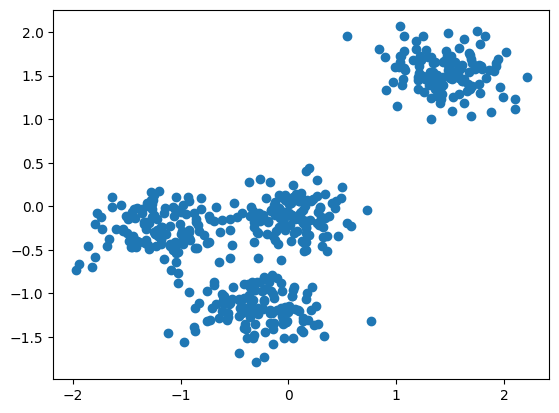

In [ ]:
X_blobs, y_blobs = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)

# Standardise features by removing the mean and scaling to unit variance
X_blobs = StandardScaler().fit_transform(X_blobs)

# Visualising via a scatter plot
plt.figure()
plt.scatter(X_blobs[:,0], X_blobs[:,1]) # X_blobs is a 2D array, to getting column 0 and 1 here
plt.show()

### Elbow method for setting _K_

This suggests setting K to 2, 3 or 4 would be good.

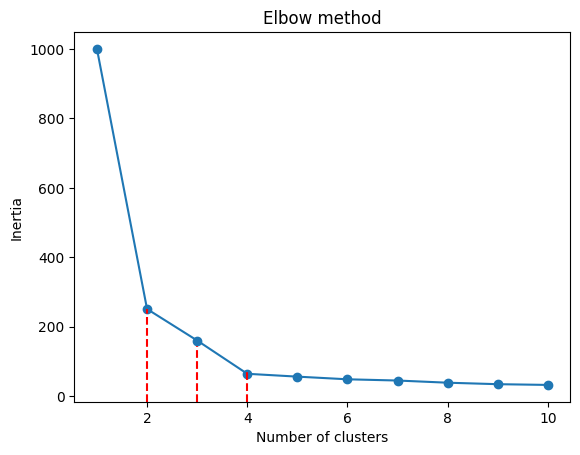

In [ ]:
inertia_list = []
n = 10

for i in range(1,n+1):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(X_blobs)
    inertia_list.append(kmeans.inertia_)

plt.plot(range(1,n+1), inertia_list, marker='o')
plt.axvline(x = 2, ymin = 0, ymax=0.25, color = 'r', linestyle ="--")
plt.axvline(x = 3, ymin = 0, ymax=0.15, color = 'r', linestyle ="--")
plt.axvline(x = 4, ymin = 0, ymax=0.08, color = 'r', linestyle ="--")
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### Silhouette method for setting _K_

This suggests setting K to 2 or 4 would be good.

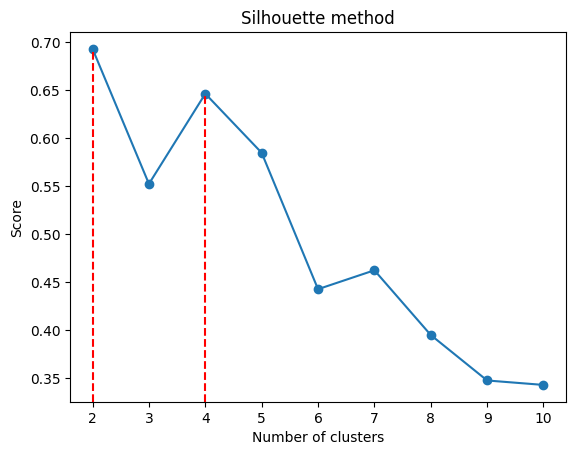

In [ ]:
silhouette_scores = []
n = 10

for i in range(2,n+1):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(X_blobs)
    score = silhouette_score(X_blobs, kmeans.predict(X_blobs))
    silhouette_scores.append(score)

plt.plot(range(2,n+1), silhouette_scores, marker='o')
plt.axvline(x = 2, ymin = 0, ymax=0.95, color = 'r', linestyle ="--")
plt.axvline(x = 4, ymin = 0, ymax=0.83, color = 'r', linestyle ="--")
plt.title('Silhouette method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

### Detailed Solhouette analysis

This helps determine the "best" value for k as 4, calling the function defined at the top of this notebook.

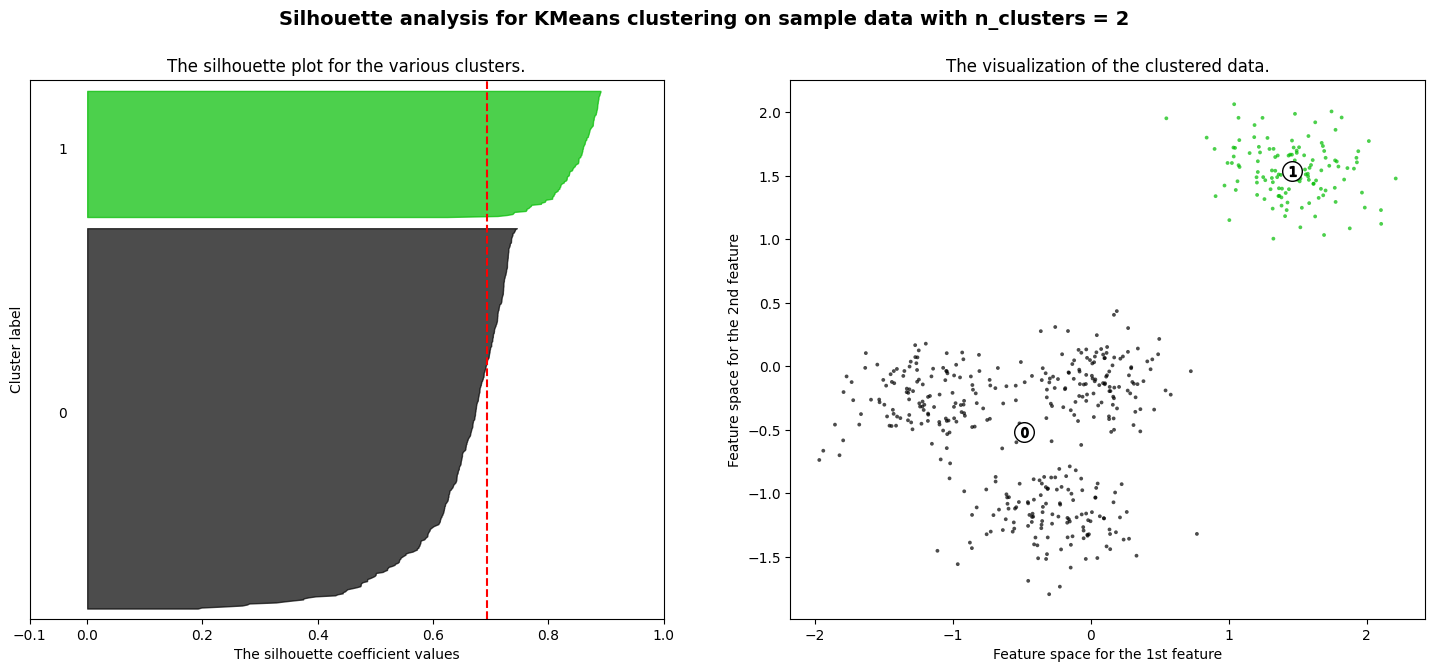

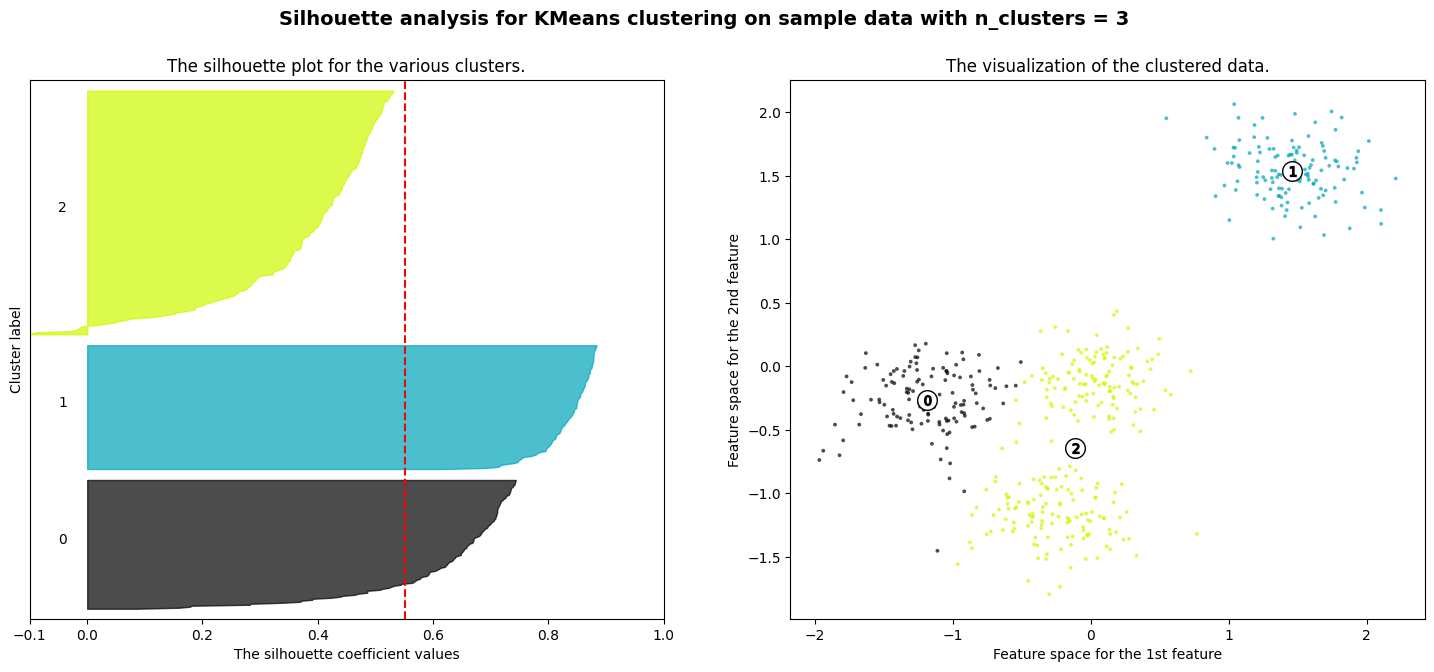

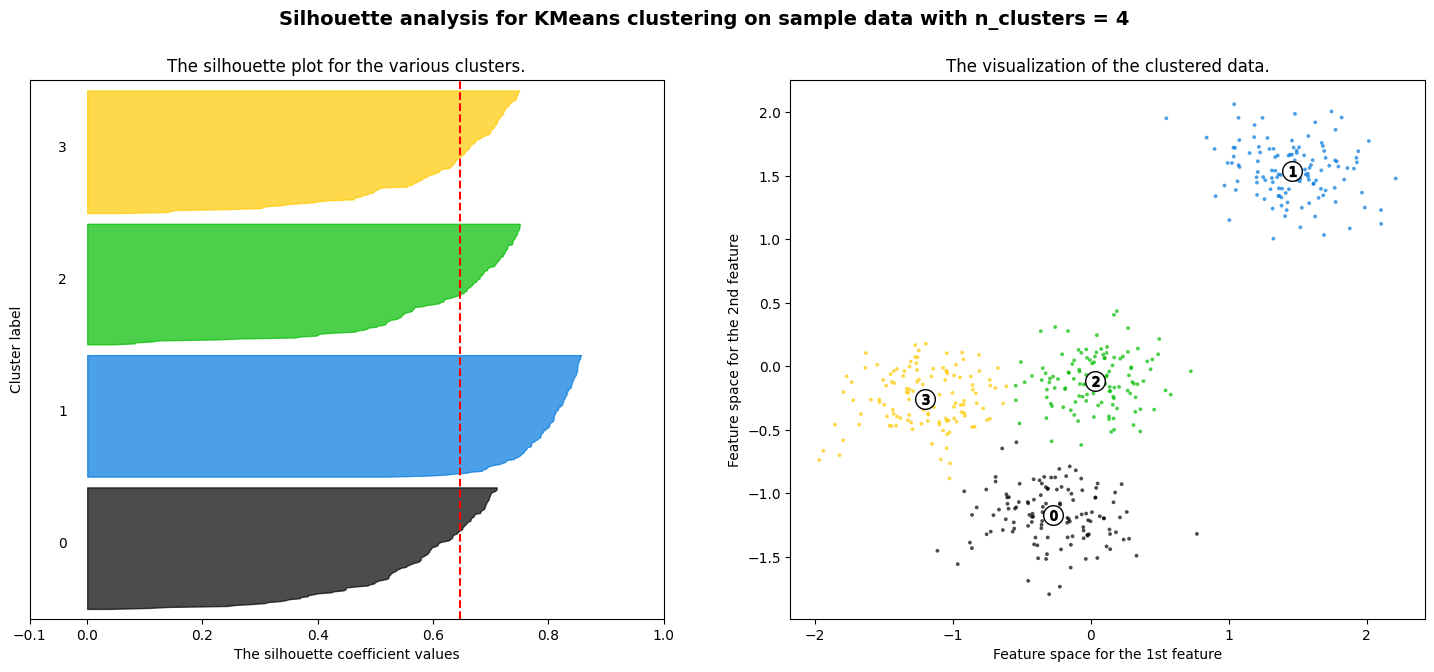

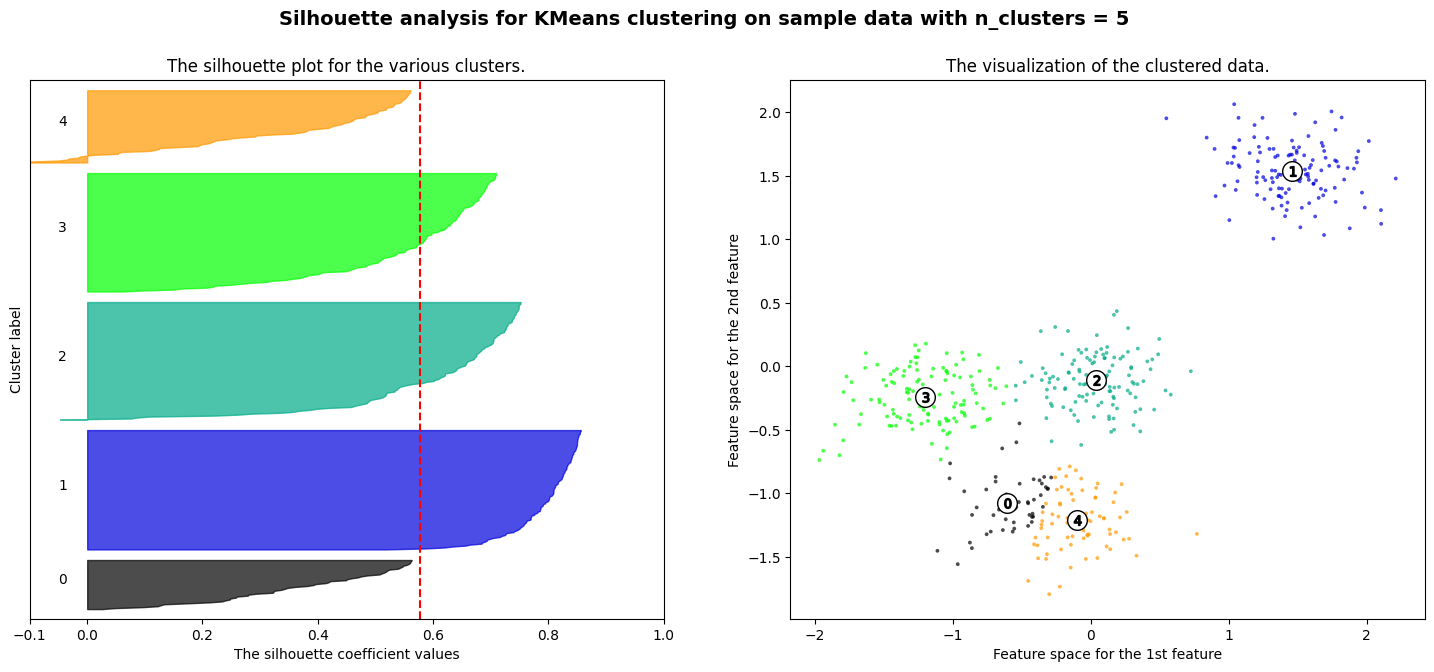

In [ ]:
cluster_values = [2, 3, 4, 5]

silhouette_analysis(X_blobs, y_blobs, cluster_values)

### K-Means

**TODO:** Run K-means here with the optimal value for _K_ following on from the analysis above!

Estimated number of clusters: 4
Estimated number of noise points: 0
Homogeneity: 0.927
Completeness: 0.927
V-measure: 0.927
Adjusted Rand Index: 0.943
Adjusted Mutual Information: 0.927
Silhouette Coefficient: 0.646


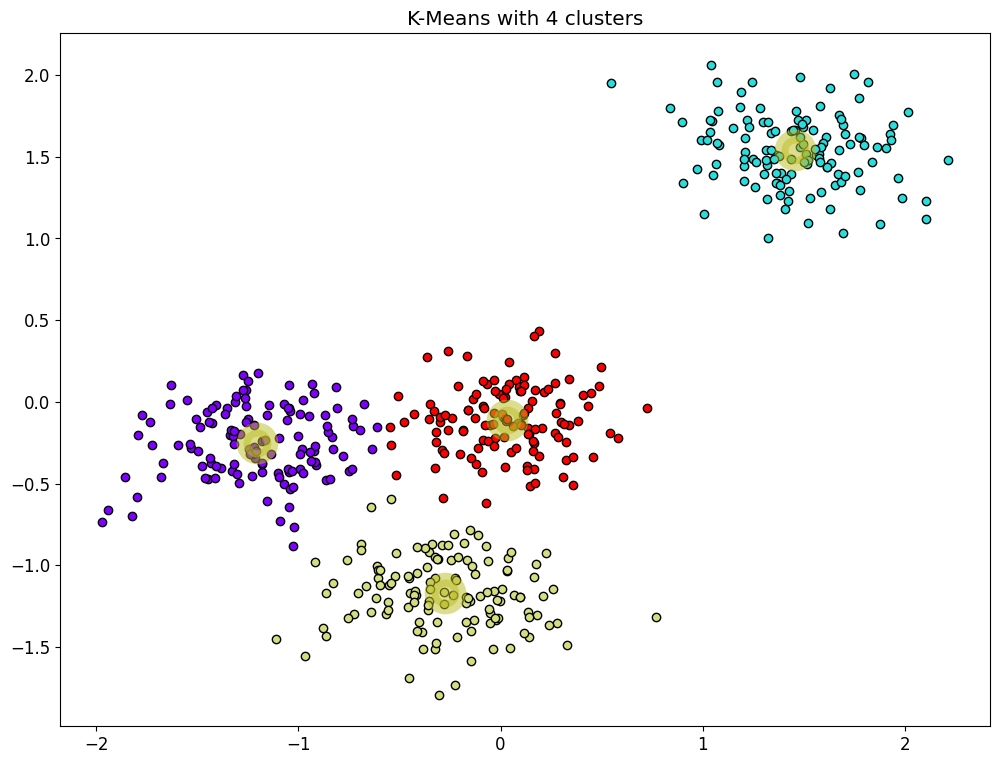

In [ ]:
model = KMeans(n_clusters=4, n_init='auto')
model = model.fit(X_blobs)
labels = model.labels_
cluster_centres = model.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just an Numpy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Print stats and plot graph
print_stats(n_clusters_, n_noise_, X_blobs, y_blobs, labels)
plot_cluster_graph(X_blobs, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

### DBSCAN

**TODO**: tweak the values for ``eps`` and ``min_samples`` to get some sensible results.

Estimated number of clusters: 4
Estimated number of noise points: 73
Homogeneity: 0.809
Completeness: 0.701
V-measure: 0.751
Adjusted Rand Index: 0.743
Adjusted Mutual Information: 0.749
Silhouette Coefficient: 0.497


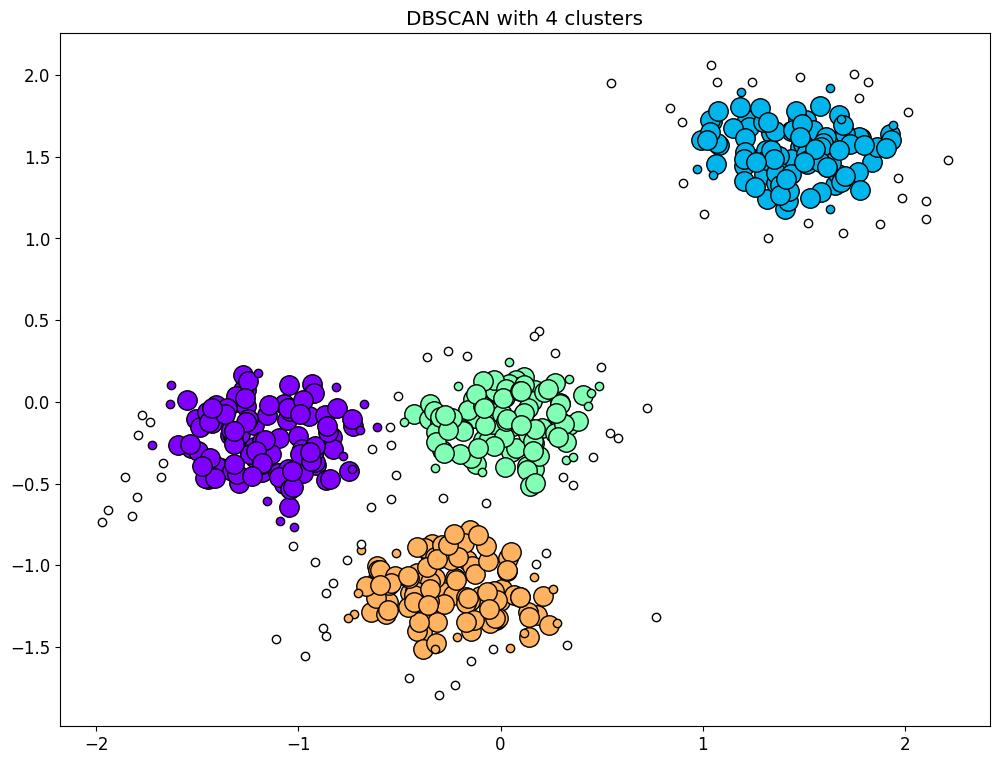

In [ ]:
model = DBSCAN(eps=0.13, min_samples=5)
model = model.fit(X_blobs)
labels = model.labels_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

print_stats(n_clusters_, n_noise_, X_blobs, y_blobs, labels)
plot_cluster_graph(X_blobs, labels, core_samples_mask, 'DBSCAN', n_clusters_)

## Circle data analysis

### Dataset

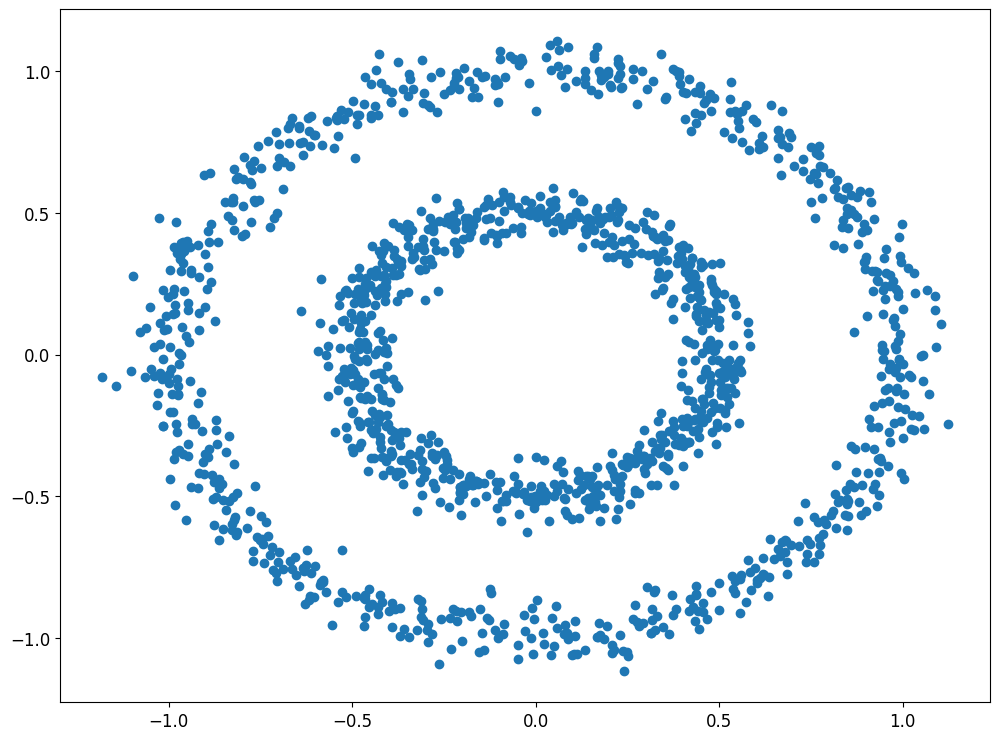

In [ ]:
circles = make_circles(n_samples=1500, factor=.5, noise=.05)
X_circles = circles[0]
y_circles = circles[1]

plt.figure()
plt.scatter(X_circles[:,0], X_circles[:,1])

### K-Means

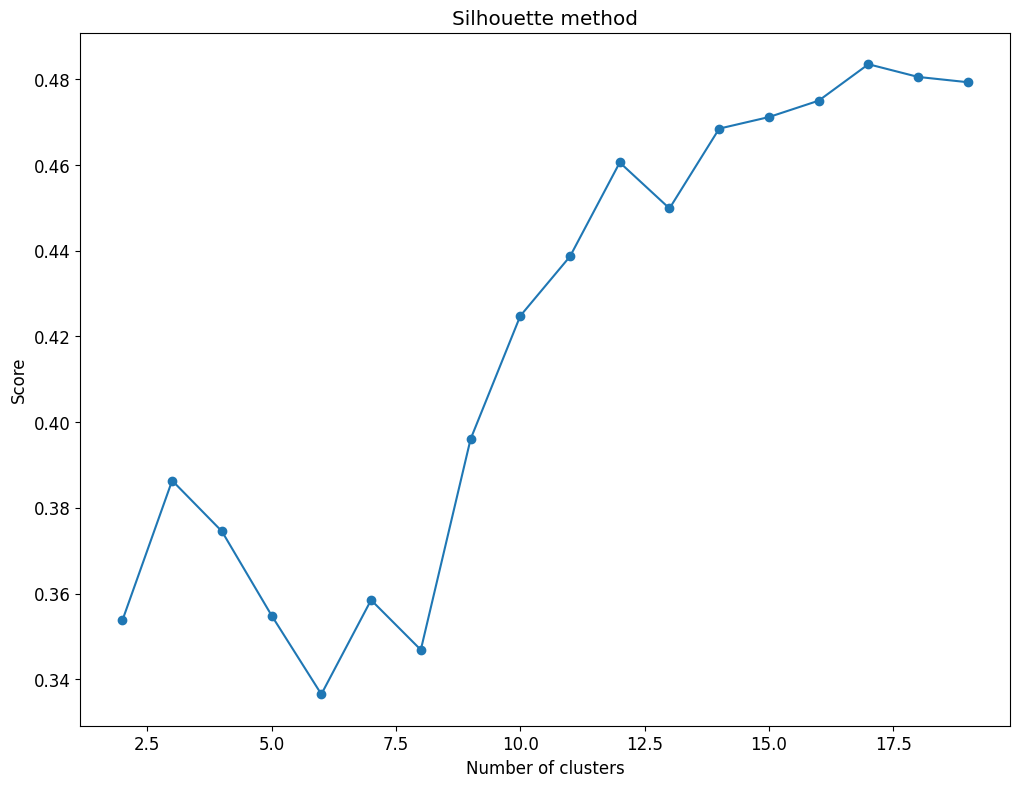

In [ ]:
silhouette_scores = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(X_circles)
    score = silhouette_score(X_circles, kmeans.predict(X_circles))
    silhouette_scores.append(score)

plt.plot(range(2,20), silhouette_scores, marker='o')
plt.title('Silhouette method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

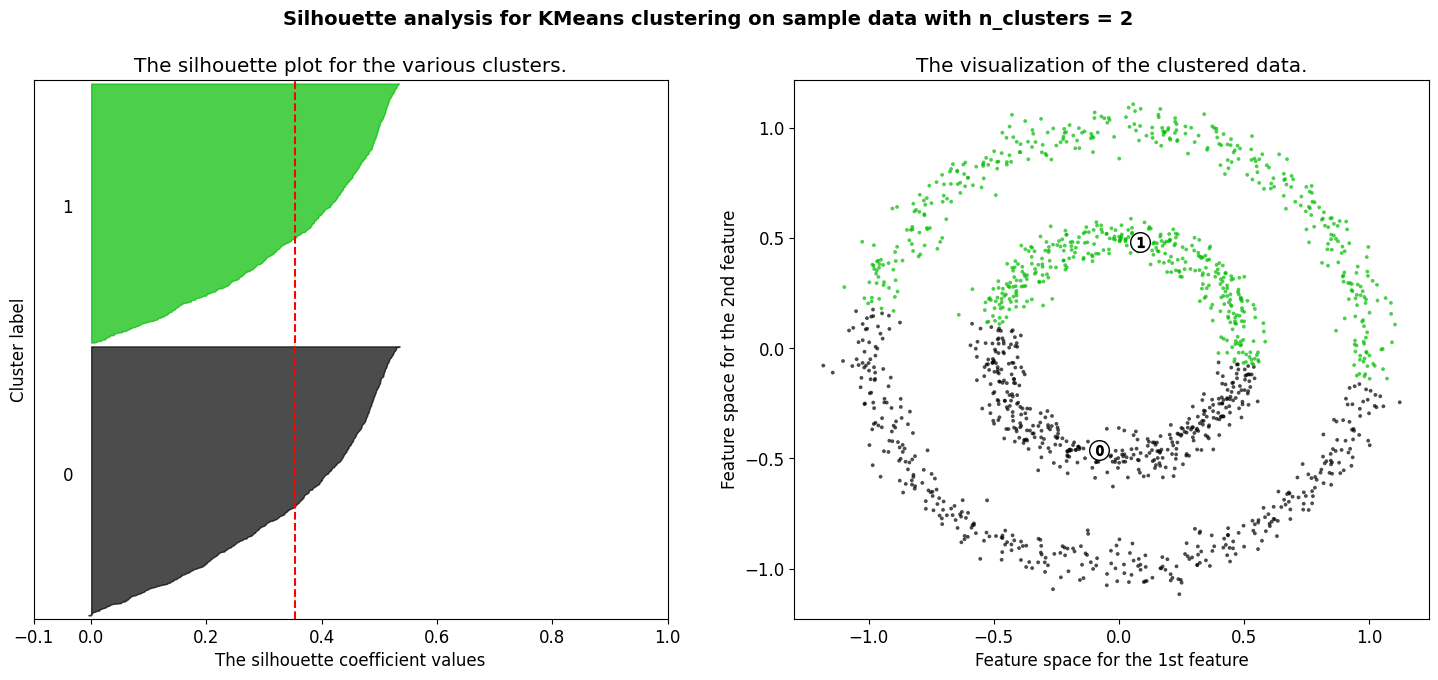

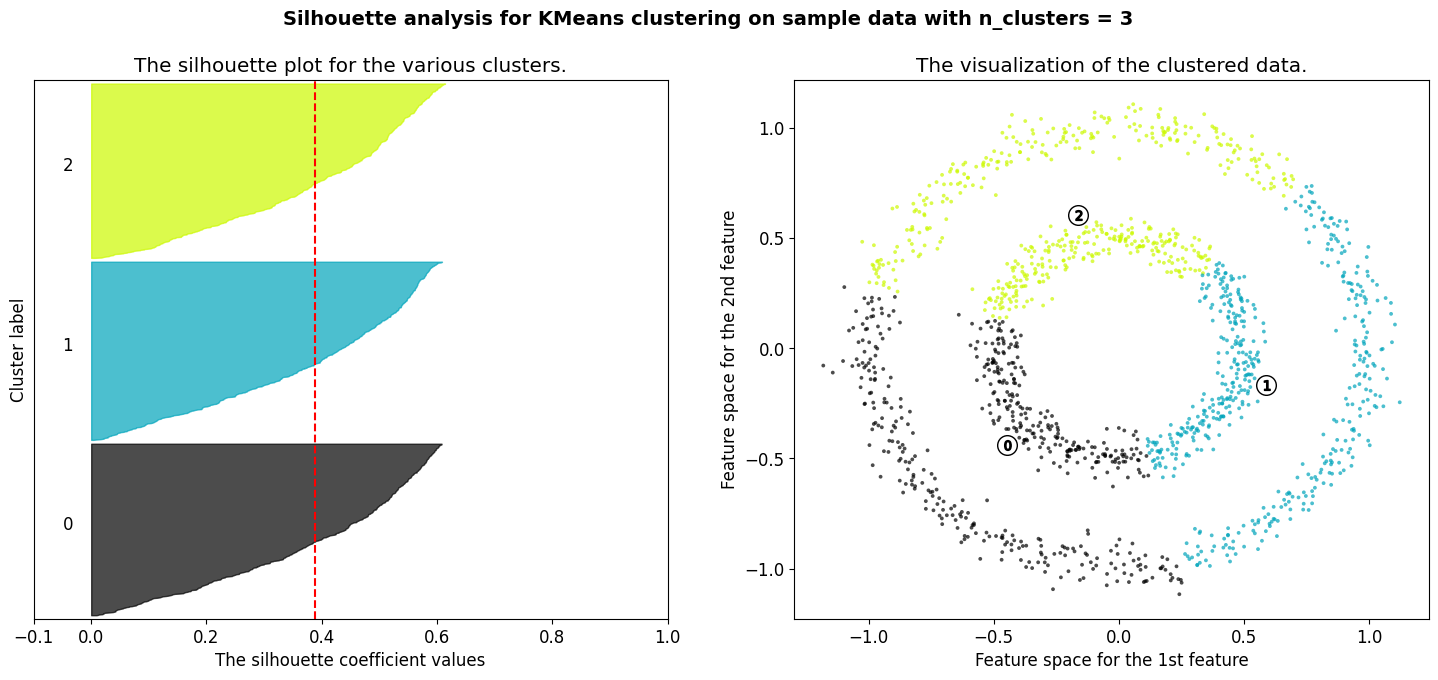

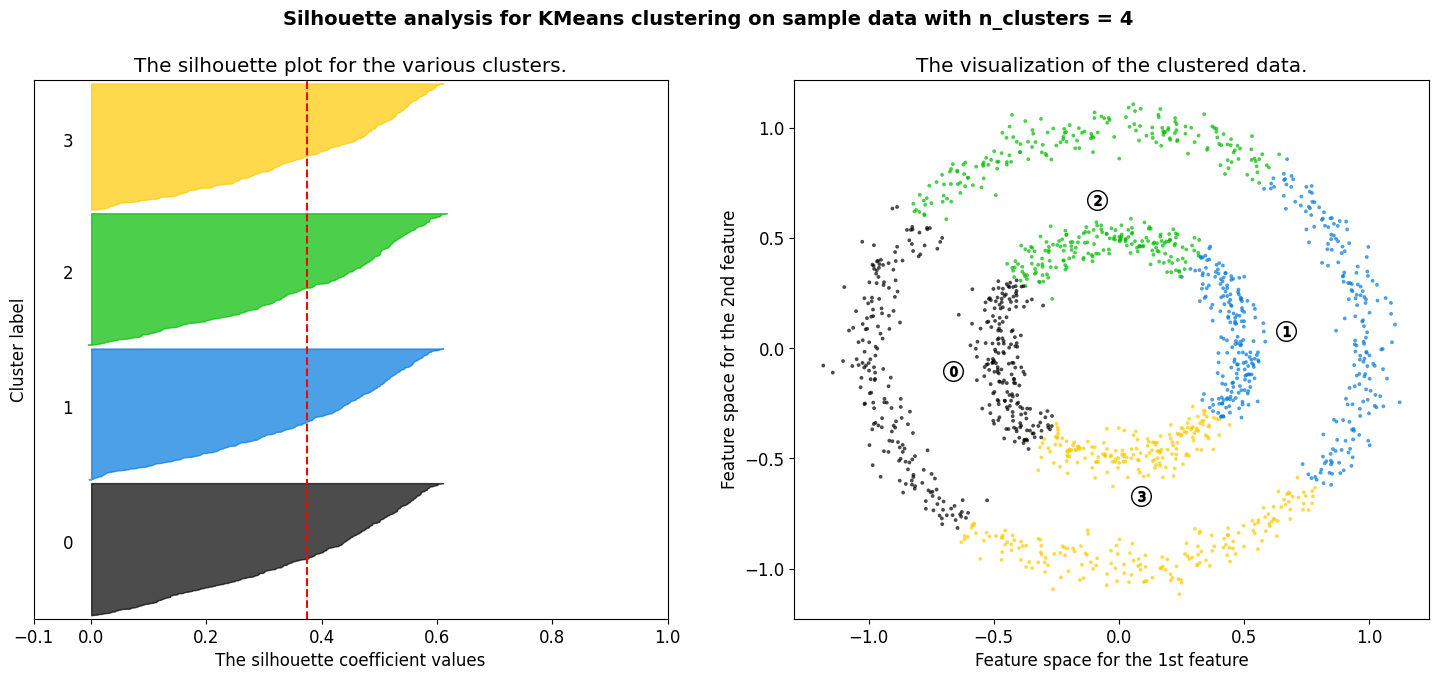

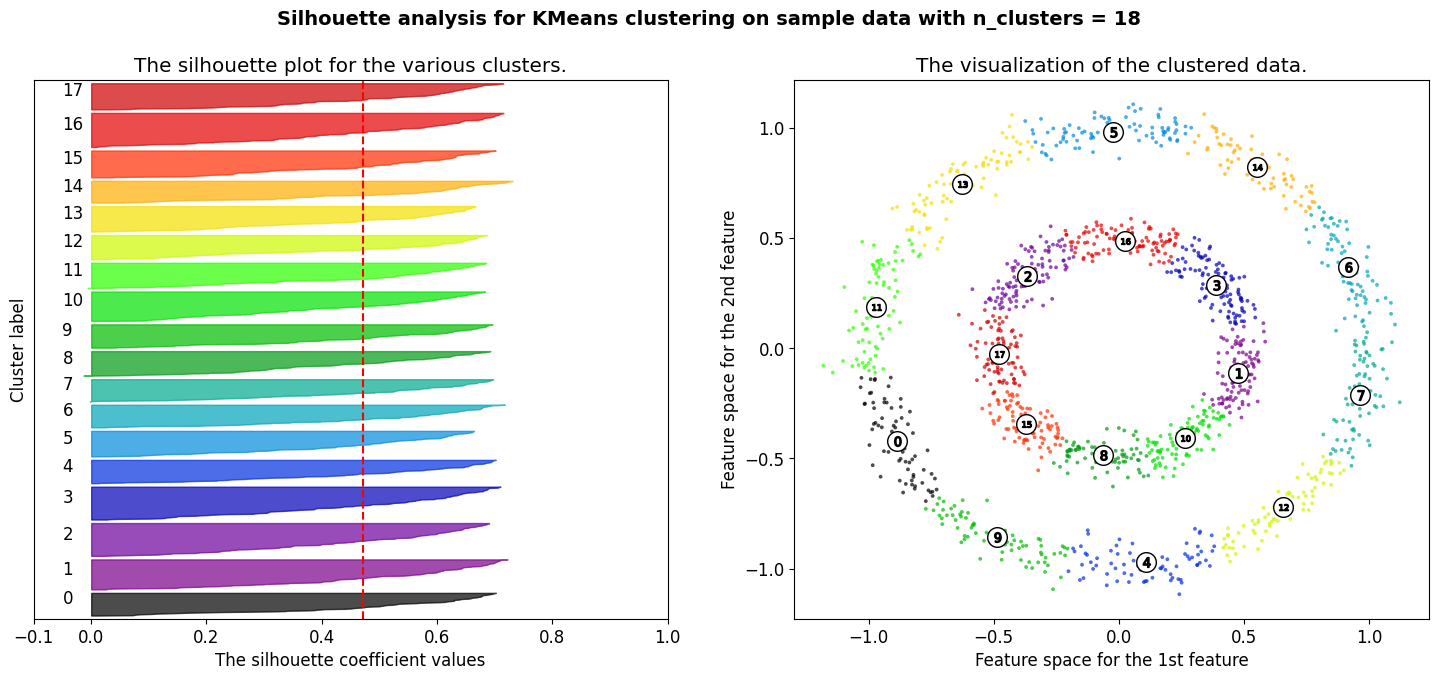

In [ ]:
cluster_values = [2, 3, 4, 18]

silhouette_analysis(X_circles, y_circles, cluster_values)

Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.354


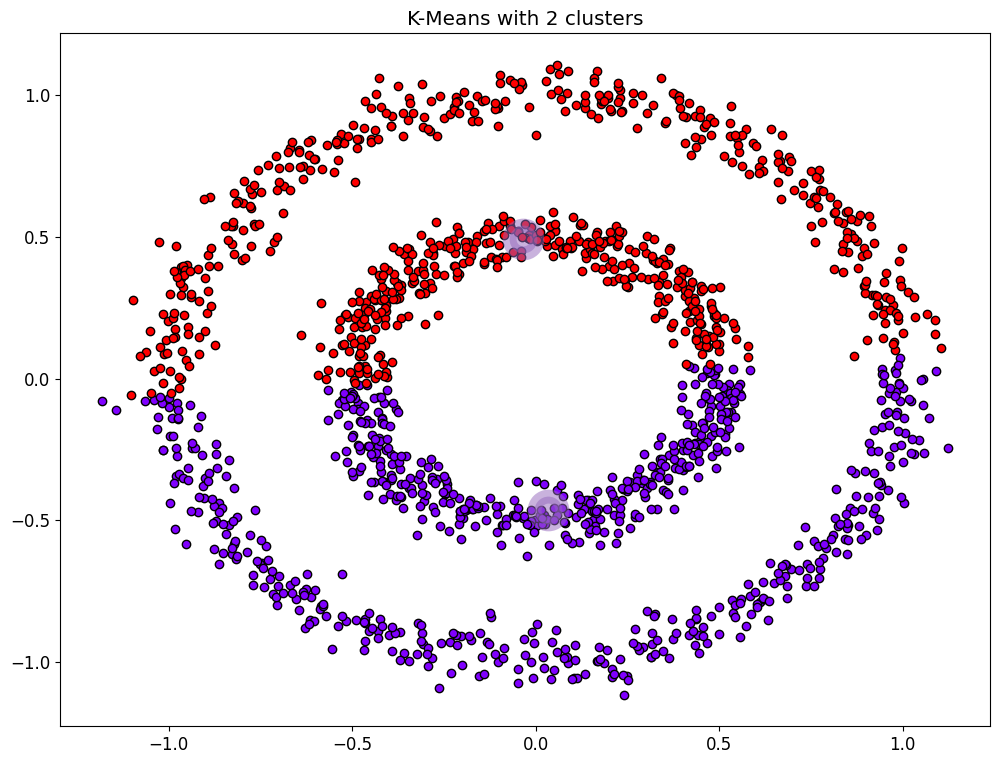

In [ ]:
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans = kmeans.fit(X_circles)
labels = kmeans.labels_
cluster_centres = kmeans.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just an Numpy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Print stats and plot graph
print_stats(n_clusters_, n_noise_, X_circles, y_circles, labels)
plot_cluster_graph(X_circles, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

### DBSCAN

**TODO**: tweak the values for ``eps`` and ``min_samples`` to get some sensible results.

In [ ]:
db = DBSCAN(eps=0.1, min_samples=20)
db = db.fit(X_circles)
labels = db.labels_

print(labels)

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

print_stats(n_clusters_, n_noise_, X_circles, y_circles, labels)
plot_cluster_graph(X_circles, labels, core_samples_mask, 'DBSCAN', n_clusters_)

## Clustering on the Iris dataset

An example of something you could do for the assignment dataset.

### Dataset

In [ ]:
# load the iris.arff data set
iris_df = pd.read_csv('data/iris.csv')

# print the top of the file (just to check it's read and processed OK)
iris_df.head()

### K-Means

#### Sepal length and width

To start with, simplifying this by using only 2 dimensions (features).

In [ ]:
X_iris = iris_df[["Sepal length", "Sepal width"]]
X_iris = StandardScaler().fit_transform(X_iris)

plt.figure()
plt.scatter(X_iris[:,0], X_iris[:,1])
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans = kmeans.fit(X_iris)
labels = kmeans.labels_
cluster_centres = kmeans.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just a NumPy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Visualising the clusters
plot_cluster_graph(X_iris, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

#### All features

Note where the centroids end up, when doing it based on all features, but visualising the same two dimensions as above!

In [ ]:
# Slices the Pandas DataFrame to get the entire feature matrix (X)
X_iris = iris_df.iloc[:,:len(iris_df.columns)-2]
X_iris = StandardScaler().fit_transform(X_iris)

# Perform clustering
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans = kmeans.fit(X_iris)
labels = kmeans.labels_
cluster_centres = kmeans.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just an Numpy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Visualising the results for the same two features used above
X_iris = iris_df[["Sepal length", "Sepal width"]]
X_iris = StandardScaler().fit_transform(X_iris)
plot_cluster_graph(X_iris, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

### DBSCAN for noise detection

Here's an example for how DBSCAN can be used for noise detection.

First with 2 features, and then with all features.

#### Sepal length and width

In [ ]:
X_iris = iris_df[["Sepal length", "Sepal width"]]
X_iris = StandardScaler().fit_transform(X_iris)

db = DBSCAN(eps=0.5, min_samples=10).fit(X_iris)
labels = db.labels_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Printing some stats
# can't do all stats as above, as we don't have a ground truth of what clusters
# each data point should belong to as in the test data
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Plotting the clustering outputs
plot_cluster_graph(X_iris, labels, core_samples_mask, 'DBSCAN', n_clusters_)

#### All features

Note differences in potential noise when using all features, but visualising the same two dimensions as above!

In [ ]:
# Slices the Pandas DataFrame to get the entire feature matrix (X)
X_iris = iris_df.iloc[:,:len(iris_df.columns)-1]

# Scales the feature values
X_iris = StandardScaler().fit_transform(X_iris)

db = DBSCAN(eps=0.8, min_samples=10).fit(X_iris)
labels = db.labels_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Printing some stats
# can't do all stats as above, as we don't have a ground truth of what clusters
# each data point should belong to as in the test data
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
# Visualising the results for the same two features used above
X_iris = iris_df[["Sepal length", "Sepal width"]]
X_iris = StandardScaler().fit_transform(X_iris)

# Plotting the clustering outputs
plot_cluster_graph(X_iris, labels, core_samples_mask, 'DBSCAN', n_clusters_)

In [ ]:
# Visualising the results for the petal length and width features
X_iris = iris_df[["Petal length", "Petal width"]]
X_iris = StandardScaler().fit_transform(X_iris)

# Plotting the clustering outputs
plot_cluster_graph(X_iris, labels, core_samples_mask, 'DBSCAN', n_clusters_)

#### Adding noise data to dataframe

In [ ]:
# Add a column to our Pandas DataFrame with default values False
iris_df_noise = iris_df.copy()
iris_df_noise['NOISY'] = False

# Print which instances were noisy,
# and set flag in our new column to True for the noisy instances
print("Noisy instances / rows")
for i in range(labels.size):
    if labels[i] == -1:
        print("\t", i)
        iris_df_noise.at[i, 'NOISY'] = True

# print out rows 30-34, so you can see instance 33 noted as noisy
iris_df_noise.iloc[115:135].head(30)

#### Saving CSV file with noise data

In [ ]:
# write new dataset file to disk
iris_df_noise.to_csv ('data/iris-noise.csv', index = False, header=True)

## Clustering with PCA (iris dataset)

### Step 1

First, preparing the data, applying PCA to reduce the 4 original features to 2.

In [ ]:
# Slices the Pandas DataFrame to get the entire feature matrix (X)
X = iris_df.iloc[:,:len(iris_df.columns)-2]
X = StandardScaler().fit_transform(X_iris)

# Slices the Pandas DataFrame to get the class column
y_iris = iris_df.iloc[:,len(iris_df.columns)-1:]

# Applying PCA to reduce the 4 features to 2 principal components
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

# Visualising via a scatter plot
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.show()

### Step 2

Then, doing analysis of silhouette scores to determine optimal value for k.

In [ ]:
# Silhouette score analysis
cluster_values = [2, 3, 4]

silhouette_analysis(X_pca, y_iris, cluster_values)

### Step 3

Then, performing clustering with k = 3, based on the above

In [ ]:
# Perform clustering
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=10)
kmeans = kmeans.fit(X_pca)
labels = kmeans.labels_
cluster_centres = kmeans.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just an Numpy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Visualising the results for the same two features used above
plot_cluster_graph(X_pca, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

### Step 4

Adding a column to the original dataframe to say which cluster each instance (row) belongs to from the above analysis.

We can then visualise this.

In [ ]:
iris_df_clusters = iris_df.copy()

iris_df_clusters["Cluster"] = labels
iris_df_clusters

In [ ]:
# Setting up colours and labels for the classes
class_params = {"Iris-setosa": {'color': 'royalblue', 'label': 'Setosa'},
          "Iris-versicolor": {'color': 'k', 'label': 'Versicolor'},
          "Iris-virginica": {'color': 'coral', 'label': 'Virginica'}}

# Setting up colours and labels for the clusters
cluster_params = {0: {'color': 'coral', 'label': 'Cluster 1'},
          1: {'color': 'royalblue', 'label': 'Cluster 2'},
          2: {'color': 'k', 'label': 'Cluster 3'}}

# Setting up a figure with two sub-plots
fig = plt.figure()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting classes
for klass, subdf in iris_df_clusters.groupby('Class'):
    sns.scatterplot(subdf, x='Sepal length', y='Sepal width',
                    ax=axs[0], **class_params[klass])

# Plotting clusters
for klass, subdf in iris_df_clusters.groupby('Cluster'):
    sns.scatterplot(subdf, x='Sepal length', y='Sepal width',
                    ax=axs[1], **cluster_params[klass])
plt.show()

In [ ]:
# Setting up colours and labels for the clusters
cluster_params = {0: {'color': 'royalblue', 'label': 'Cluster 1'},
          1: {'color': 'k', 'label': 'Cluster 2'},
          2: {'color': 'coral', 'label': 'Cluster 3'}}

# Setting up colours and labels for the classes
class_params = {"Iris-setosa": {'color': 'k', 'label': 'Setosa'},
          "Iris-versicolor": {'color': 'coral', 'label': 'Versicolor'},
          "Iris-virginica": {'color': 'royalblue', 'label': 'Virginica'}}

# Setting up a figure with two sub-plots
fig = plt.figure()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting classes
for klass, subdf in iris_df_clusters.groupby('Class'):
    sns.scatterplot(subdf, x='Petal length', y='Petal width',
                    ax=axs[0], **class_params[klass])

# Plotting clusters
for klass, subdf in iris_df_clusters.groupby('Cluster'):
    sns.scatterplot(subdf, x='Petal length', y='Petal width',
                    ax=axs[1], **cluster_params[klass])
plt.show()